### Imports

In [1]:
# Thrid party libs
from sentence_transformers import SentenceTransformer
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# System libs
import datetime as dt
import time
import os
import csv
import sys
sys.path.append(os.path.join(os.getcwd(), ".."))


# Local imports
from utils import get_average_embedding, get_similarity_scores, get_cosdiff_scores #, normalize_embeddings
import examples

/home/quentinmowat-amiet/Documents/Glassdoor/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Config

In [24]:
# Data config
DATA: str = "/media/ssdraid/quentinmowat-amiet/Dropbox (IESE)/earnings_calls/Originals/Conference Calls/OLD/ccalls_from_stata.csv"  # CCALLS_copy.csv
DTYPE: dict = {'gvkey': 'int', 'new_text': 'object'}      # {'job': str, 'year': int, 'quarter': str, 'text': str, 'conm': str, 'gvkey': float}, was throwing error
JOB: str = "CEO"

# Model config
MODEL_FAMILY: str = 'bge'
MODEL: str = f'{MODEL_FAMILY}-large-en-v1.5'
MODEL_PATH: str = f'BAAI/{MODEL}'

# Export config
# PROMPT: str = 'continuous'
EXPORT_TYPE: str = "ecalls"
EXPORT_FILE: str = f'{EXPORT_TYPE}_{MODEL_FAMILY}_{JOB}_test.csv'
EXPORT_PATH: str = f'/media/ssdraid/quentinmowat-amiet/Dropbox (IESE)/earnings_calls/outputs/'
EXPORT_DATA: str = f'{EXPORT_PATH}{EXPORT_FILE}'

EXPORT_PNG: str = 'histograms_of_scores0.png'
EXPORT_FIGURE: str = f'{EXPORT_PATH}{EXPORT_PNG}'

# Cultural/Structural attributes of interest
pos_attributes: list = ["centralized"] # , "autonomous", "transparent"]
neg_attributes: list = ["decentralized"] # , "supervised", "opaque"]

### Data

In [3]:
# Import earnings calls as dask dataframe
ddf = dd.read_csv(DATA, dtype = DTYPE)

# Subset ddf for questions from media
df = ddf[ddf['job'] == JOB].compute().reset_index(drop = True)

# Obtain array of questions from text column
answers = df['text'].values

# Import extreme reviews and example reviews
centralized_reviews = examples.centralized_ecalls
decentralized_reviews = examples.decentralized_ecalls

### Model

In [4]:
# Import model
model = SentenceTransformer(MODEL_PATH)

In [5]:
# Get embdeddings for extreme bag of reviews
centralized_embeddings = model.encode(centralized_reviews, normalize_embeddings=True)
decentralized_embeddings = model.encode(decentralized_reviews, normalize_embeddings=True)

In [6]:
#Important, you need to shield your code with if __name__. Otherwise, CUDA runs into issues when spawning new processes.
if __name__ == '__main__':

    #Start the multi-process pool on all available CUDA devices
    pool = model.start_multi_process_pool()

    # Get embeddings for answers in earnings calls
    start_time = time.time()
    answer_embeddings = model.encode_multi_process(answers, pool) 
    end_time = time.time()

    #Optional: Stop the proccesses in the pool
    model.stop_multi_process_pool(pool)

In [7]:
# Normalize embeddings
# answer_embeddings_normalized = normalize_embeddings(answer_embeddings)

In [8]:
# Get average embeddings for extremes
average_centralized = get_average_embedding(centralized_embeddings)
average_decentralized = get_average_embedding(decentralized_embeddings)

In [9]:
# Print run time
elapsed_time = dt.timedelta(seconds = (end_time - start_time))
print(f"{MODEL} model completed running in: {elapsed_time}")

bge-large-en-v1.5 model completed running in: 0:06:48.047087


In [10]:
# Get similarity of answers to centralized or decentralized average embedding
similarity_scores = get_similarity_scores(answer_embeddings, [average_centralized], [average_decentralized], pos_attributes)
cosdiff_scores = get_cosdiff_scores(answer_embeddings, [average_centralized], [average_decentralized], pos_attributes)

### Log

In [11]:
# Ebbeding counts and dimensions
EMBEDDING_COUNT = len(answer_embeddings)
EMBEDDING_DIMS = len(answer_embeddings[0])

# Define the CSV file path
csv_file_path = os.getenv('CSV_FILE', 'log.csv')

# Define the headers for the CSV file
headers = ['time', 'embeddings', 'dimensions', 'data', 'subset', 'model']

# Create a list with the data to be written
data = [
    {'time': end_time - start_time, 'embeddings': EMBEDDING_COUNT, 'dimensions': EMBEDDING_DIMS, 'data': EXPORT_TYPE, 'subset': JOB, 'model': MODEL}
]

# Check if the file exists
file_exists = os.path.isfile(csv_file_path)

# Open the CSV file in append mode
with open(csv_file_path, 'a', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=headers)

    # Write header only if the file is being created for the first time
    if not file_exists:
        writer.writeheader()

    # Append data to the CSV file
    writer.writerows(data)

### Export

In [12]:
# Convert responses dictionary to a DataFrame
df_similarity = pd.DataFrame(similarity_scores).T
df_cosdiff = pd.DataFrame(cosdiff_scores).T

# Merge results df to subset df
df_result = (
    df.merge(df_similarity.rename(columns={'centralized': 'similarity'}), left_index=True, right_index=True, how='left')
      .merge(df_cosdiff.rename(columns={'centralized': 'cos_diff'}), left_index=True, right_index=True, how='left')
)

# Save results df to csv
df_result.to_csv(EXPORT_PATH, index = False)

### EDA

In [13]:
df_result.head()

,name,company,job,year,quarter,text,document,year_in_file,year_f,year_final,...,merger,acquisition,_merge,conm,gvkey,question_intext,analyst,new_text,similarity,cos_diff
0,CHRISTIE HEFNER,PLAYBOY ENTERPRISES,CEO,2002,Q2,The quarter demonstrates our ability to delive...,fndw000020020807dy86000rw,2002,2002,2002,...,1,0,both in master and using data,Playboy Enterprises,8638,1,0,NaN,0.047633,0.005219
1,AUBREY MCCLENDON,CHESAPEAKE ENERGY,CEO,2002,Q2,Good morning and thank you for joining Chesape...,fndw000020020809dy7q00001,2002,2002,2002,...,0,1,both in master and using data,Chesapeake Energy,27786,1,0,NaN,0.069001,0.009434
2,STEVE DODGE,AMERICAN TOWER,CEO,2002,Q2,"Thanks, Jim. Our core tower business continues...",fndw000020020809dy8800002,2002,2002,2002,...,0,1,both in master and using data,American Tower,105365,1,0,NaN,0.065635,0.009443
3,DAVID ROBINSON,LIGAND PHARMACEUTICALS,CEO,2002,Q2,Thanks Mike and thanks everyone for joining us...,fndw000020020821dy8e000yz,2002,2002,2002,...,0,0,both in master and using data,Ligand Pharmaceuticals,25937,1,0,NaN,0.061411,0.008369
4,LARRY CASTELLANI,ADVANCE AUTO PARTS,CEO,2002,Q2,"Thanks, Eric. Good morning, and welcome to our...",fndw000020020821dy8f000zp,2002,2002,2002,...,0,1,both in master and using data,Advance Auto Parts,145977,1,0,NaN,0.084109,0.012983


In [14]:
df_result['similarity'].describe()

count    21779.000000
mean         0.034401
std          0.063930
min         -0.211443
25%         -0.008680
50%          0.033150
75%          0.076384
max          0.355045
Name: similarity, dtype: float64

In [15]:
df_result['cos_diff'].describe()

count    21779.000000
mean         0.002632
std          0.012819
min         -0.045088
25%         -0.005986
50%          0.002382
75%          0.011080
max          0.067318
Name: cos_diff, dtype: float64

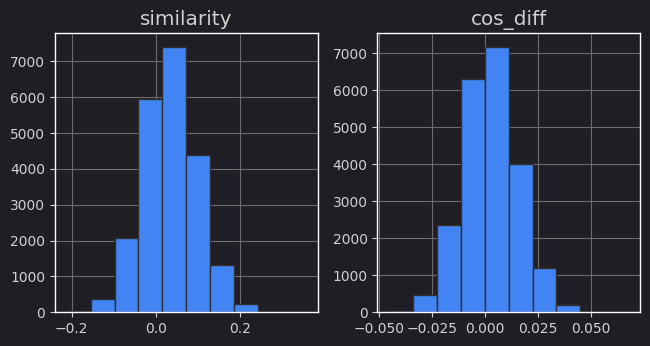

In [23]:
background_color = '#1E1E24'    # Dark background
bin_color = '#4384F5'           # Deep blue for bins
grid_line_color = '#6C6C6C'     # Light color for grid lines
title_color = '#D1D1D1'         # Light color for titles
outline_color = '#2F2F2F'       # A different shade for bin outlines

# Histograms for similarity measures
hist, ax = plt.subplots(nrows=1, ncols=2, figsize=(6.60, 3.56))
hist.set_facecolor(background_color)  # Set the background color of the entire figure

# Set common properties for all axes, ticks, and labels
for ax, var in zip(ax.flat, df_result.columns[[-2, -1]]):
    ax.hist(df_result[var], linewidth=1, edgecolor=outline_color, color=bin_color)
    ax.set_facecolor(background_color)  # Set the background color of the axes

    ax.set_title(var, color=title_color)

    ax.xaxis.label.set_color(title_color)  # Set color of x-axis label
    ax.yaxis.label.set_color(title_color)  # Set color of y-axis label

    ax.tick_params(axis='x', colors=title_color)  # Set color of x-axis ticks
    ax.tick_params(axis='y', colors=title_color)  # Set color of y-axis ticks

    ax.grid(color=grid_line_color)  # Set color of grid lines

plt.tight_layout()

In [25]:
# Save figures
plt.savefig(EXPORT_FIGURE, dpi=300)  # Adjust the file name and dpi as needed

<Figure size 640x480 with 0 Axes>